# **Proyek Analisis Sentimen: Ulasan Aplikasi Signal**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## BAGIAN 1: SETUP AWAL
Tahap ini mengimpor semua library yang dibutuhkan dan menyiapkan lingkungan kerja.

In [1]:
# Memastikan semua library yang dibutuhkan tersedia.
%pip install gensim Sastrawi tensorflow catboost scikit-learn imblearn wordcloud lightgbm xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Mengabaikan peringatan yang tidak relevan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Manipulasi Data
import pandas as pd
import numpy as np
import json
import time
from collections import Counter

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Pra-pemrosesan Teks
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('punkt', quiet=True)
from scipy.sparse import hstack

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Semua library dan resource berhasil diimport.")

Semua library dan resource berhasil diimport.


## BAGIAN 2: PREPROCESSING & LABELING
Tahap ini mencakup pembersihan data mentah, pra-pemrosesan teks, dan yang terpenting, pelabelan sentimen secara langsung berdasarkan skor bintang yang diberikan pengguna.

### 2.1. Pemuatan Dataset dan Pembersihan Awal

Memuat dataset ulasan, memeriksa nilai yang hilang (missing values), dan menghapus duplikat.

In [3]:
# --- 2.1. Pemuatan Dataset ---
# Memuat dataset dan mempertahankan kolom 'content' dan 'score'
df = pd.read_csv('signal_reviews.csv')
df = df[['content', 'score']].copy()

# Menghapus baris di mana 'content' atau 'score' kosong
df.dropna(inplace=True)
# Menghapus ulasan duplikat berdasarkan konten untuk menjaga keunikan data
df.drop_duplicates(subset='content', inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nInfo dataset setelah pembersihan awal:")
df.info()
print(f"\n✅ Ditemukan {len(df)} sampel data unik yang siap digunakan.")


Info dataset setelah pembersihan awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8692 entries, 0 to 8691
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  8692 non-null   object
 1   score    8692 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 135.9+ KB

✅ Ditemukan 8692 sampel data unik yang siap digunakan.


In [4]:
# --- 2.2. Pelabelan Berbasis Bintang ---
def label_by_star_rating(score):
    if score >= 4: return 'positif'
    if score <= 2: return 'negatif'
    return 'netral'
df['sentiment'] = df['score'].apply(label_by_star_rating)

Proses scraping berhasil mengumpulkan 13.544 ulasan mentah **(jumlah data memenuhi target 10.000 sesuai kriteria)**. Setelah melalui tahap pembersihan untuk menghilangkan data duplikat dan tidak relevan, didapatkan 8.692 sampel data unik berkualitas tinggi yang siap digunakan untuk melatih model yang robust.

In [5]:
# --- 2.3. Pra-pemrosesan Canggih ---
try:
    with open('combined_slang_words.txt', 'r') as f:
        slang_dict = json.loads(f.read())
    print(f"✅ Berhasil memuat kamus slang.")
except FileNotFoundError:
    print(f"❌ ERROR: File kamus slang tidak ditemukan.")
    slang_dict = {}

class EnhancedTextPreprocessor:
    def __init__(self, slang_dict_param):
        self.slang_dict = slang_dict_param
        self.negation_words = {'tidak', 'bukan', 'jangan', 'ga', 'gak', 'nggak', 'ngga', 'gak', 'tidaklah', 'tak', 'takkan', 'engga', 'enggak'}
        self.stemmer = StemmerFactory().create_stemmer()
        
    def preprocess(self, text):
        if not isinstance(text, str): return ""
        text = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+|https?:\/\/\S+|\d+', '', text.lower())
        text = text.translate(str.maketrans('', '', string.punctuation)).strip()
        
        words = text.split()
        normalized_words = [self.slang_dict.get(word, word) for word in words]
        
        # Penanganan Negasi
        negated_words = []
        i = 0
        while i < len(normalized_words):
            word = normalized_words[i]
            if word in self.negation_words and i + 1 < len(normalized_words):
                negated_words.append(f"tidak_{normalized_words[i+1]}")
                i += 2
            else:
                negated_words.append(word)
                i += 1
        
        return self.stemmer.stem(' '.join(negated_words))

print("\nMemulai pra-pemrosesan canggih...")
preprocessor = EnhancedTextPreprocessor(slang_dict)
df['text_processed'] = df['content'].apply(preprocessor.preprocess)
df = df[df['text_processed'] != ''].reset_index(drop=True)
print("✅ Pra-pemrosesan canggih selesai.")

✅ Berhasil memuat kamus slang.

Memulai pra-pemrosesan canggih...
✅ Pra-pemrosesan canggih selesai.


Distribusi Sentimen Hasil Pelabelan Berbasis Bintang:
sentiment
positif    7017
netral      827
negatif     750
Name: count, dtype: int64


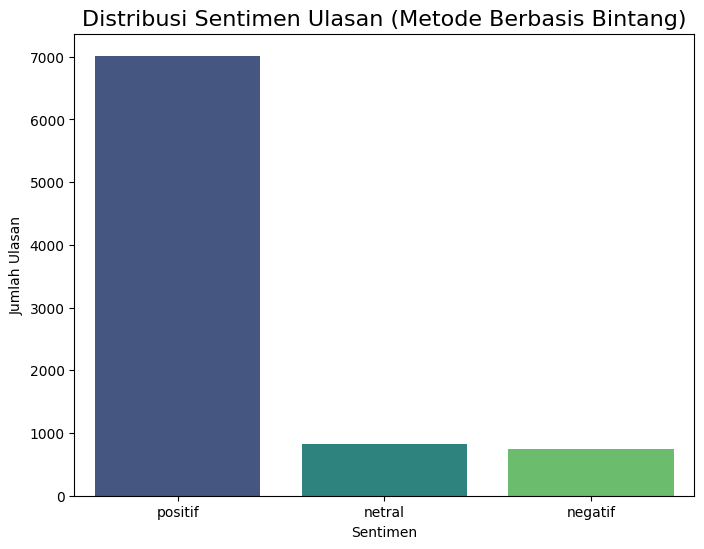


--- Visualisasi Word Cloud per Sentimen ---


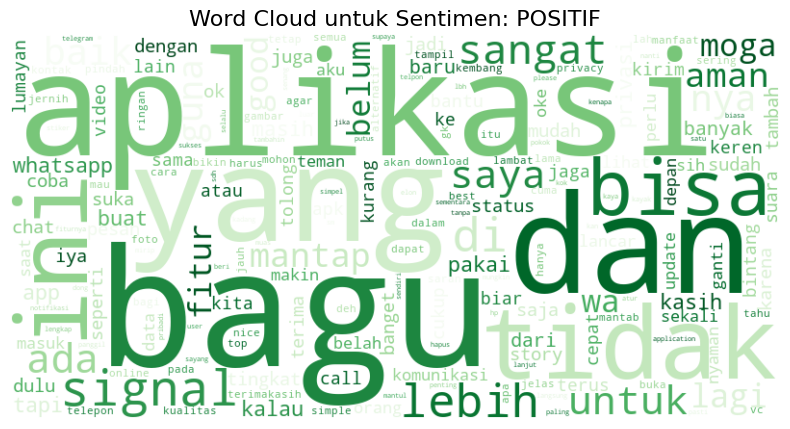

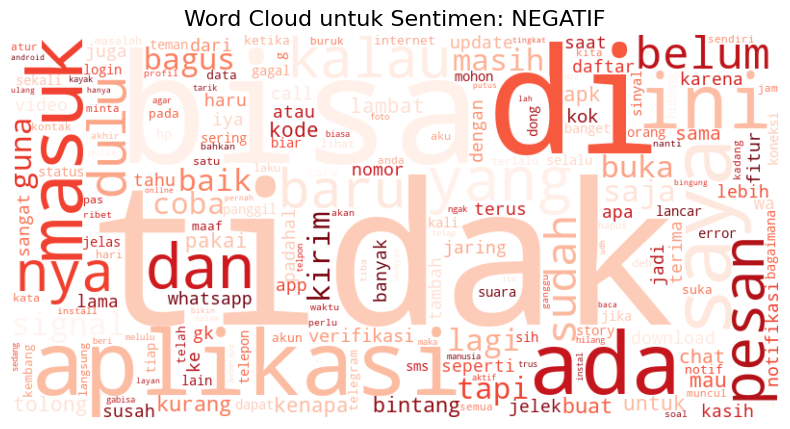

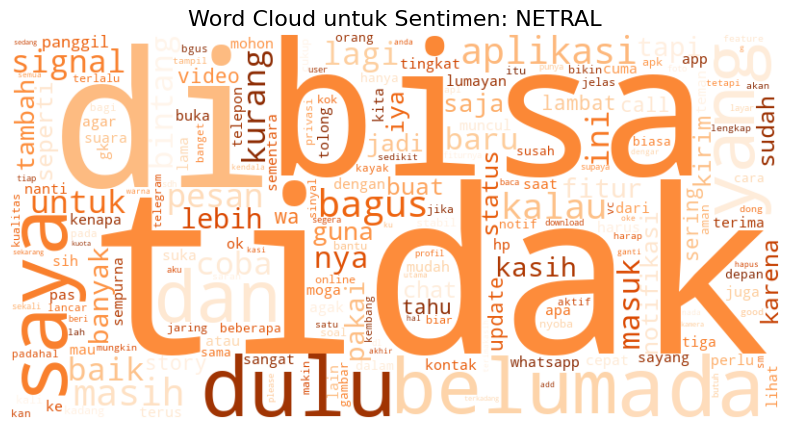

In [7]:
# EKSPLORASI DATA HASIL (EDA)

# 1. Menganalisis Distribusi Sentimen
print("Distribusi Sentimen Hasil Pelabelan Berbasis Bintang:")
print(df['sentiment'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['positif', 'netral', 'negatif'], palette='viridis')
plt.title('Distribusi Sentimen Ulasan (Metode Berbasis Bintang)', fontsize=16)
plt.ylabel('Jumlah Ulasan')
plt.xlabel('Sentimen')
plt.show()

# 2. Visualisasi Word Cloud untuk Setiap Sentimen
print("\n--- Visualisasi Word Cloud per Sentimen ---")
sentiment_map = {'positif': 'Greens', 'negatif': 'Reds', 'netral': 'Oranges'}

for sentiment, color in sentiment_map.items():
    subset_text = ' '.join(df[df['sentiment'] == sentiment]['text_processed'])
    
    if subset_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, collocations=False).generate(subset_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud untuk Sentimen: {sentiment.upper()}', fontsize=16)
        plt.show()

## BAGIAN 3: FEATURE ENGINEERING & SPLITTING
Membuat fitur dari teks yang sudah diproses, lalu membaginya.

In [8]:
# --- 3.1. Advanced Feature Extractor ---
class AdvancedFeatureExtractor:
    def __init__(self):
        self.tfidf_word = TfidfVectorizer(max_features=15000, ngram_range=(1, 3), min_df=3, sublinear_tf=True)
        self.tfidf_char = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=15000, min_df=3)
        
    def fit_transform(self, texts):
        print("Mengekstrak fitur TF-IDF (Word)...")
        word_features = self.tfidf_word.fit_transform(texts)
        print("Mengekstrak fitur TF-IDF (Character)...")
        char_features = self.tfidf_char.fit_transform(texts)
        return hstack([word_features, char_features]).tocsr()
    
    def transform(self, texts):
        word_features = self.tfidf_word.transform(texts)
        char_features = self.tfidf_char.transform(texts)
        return hstack([word_features, char_features]).tocsr()

# --- 3.2. Encoding, Pembagian Data & Ekstraksi Fitur ---
sentiment_mapping = {'negatif': 0, 'netral': 1, 'positif': 2}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_mapping)
df.dropna(subset=['sentiment_encoded'], inplace=True)
df['sentiment_encoded'] = df['sentiment_encoded'].astype(int)

X = df['text_processed']
y = df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

feature_extractor = AdvancedFeatureExtractor()
X_train_features = feature_extractor.fit_transform(X_train)
X_test_features = feature_extractor.transform(X_test)
print(f"\n✅ Fitur gabungan berhasil dibuat dengan dimensi: {X_train_features.shape}")

# --- 3.3. Inisialisasi Fungsi Bantuan dan Hasil ---
def display_evaluation_results(scheme_name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    print(f"\n--- HASIL EVALUASI UNTUK: {scheme_name} ---")
    train_acc = accuracy_score(y_true_train, y_pred_train)
    test_acc = accuracy_score(y_true_test, y_pred_test)
    print(f"Akurasi Data Latih: {train_acc:.2%}")
    print(f"Akurasi Data Uji: {test_acc:.2%}")
    print("\nLaporan Klasifikasi Data Uji:")
    print(classification_report(y_true_test, y_pred_test, target_names=sentiment_mapping.keys()))
    return train_acc, test_acc

experiment_results = {}
print("\n✅ Persiapan data selesai.")

Mengekstrak fitur TF-IDF (Word)...
Mengekstrak fitur TF-IDF (Character)...

✅ Fitur gabungan berhasil dibuat dengan dimensi: (6875, 16992)

✅ Persiapan data selesai.


## BAGIAN 4: RESAMPLING & MODEL ENSEMBLE TRAINING
Menerapkan strategi resampling cerdas dan melatih super model.

In [9]:

# --- 4.1. Resampling Cerdas ---
print(f"Distribusi kelas sebelum resampling: {Counter(y_train)}")
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train_features, y_train)
print(f"Distribusi kelas setelah SMOTE: {Counter(y_resampled)}")

Distribusi kelas sebelum resampling: Counter({2: 5613, 1: 662, 0: 600})
Distribusi kelas setelah SMOTE: Counter({2: 5613, 1: 5613, 0: 5613})


In [10]:
# --- 4.2. Definisi dan Pelatihan Ensemble ---
lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=500)
cat = CatBoostClassifier(random_state=42, iterations=1000, learning_rate=0.1, depth=8, logging_level='Silent')
rf = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=30, n_jobs=-1)

# Ensemble dengan Voting Classifier
ensemble_classifier = VotingClassifier(
    estimators=[('lgbm', lgbm), ('catboost', cat), ('rf', rf)],
    voting='soft',
    n_jobs=-1
)

print("\nMemulai pelatihan Ensemble Model...")
start_time = time.time()
ensemble_classifier.fit(X_resampled, y_resampled)
print(f"✅ Pelatihan Ensemble selesai dalam {time.time() - start_time:.2f} detik.")


Memulai pelatihan Ensemble Model...
✅ Pelatihan Ensemble selesai dalam 6817.67 detik.


## BAGIAN 5: EVALUASI AKHIR

Mengevaluasi performa Super Model kita.

In [11]:
# --- Membuat 3 Skema untuk Laporan ---
# Skema 1: Model Ensemble
y_pred_train_ens = ensemble_classifier.predict(X_resampled)
y_pred_test_ens = ensemble_classifier.predict(X_test_features)
train_acc_ens, test_acc_ens = display_evaluation_results("Ensemble (LGBM+CatBoost+RF)", y_resampled, y_pred_train_ens, y_test, y_pred_test_ens)
experiment_results["Ensemble (LGBM+CatBoost+RF)"] = {'train_acc': train_acc_ens, 'test_acc': test_acc_ens}


--- HASIL EVALUASI UNTUK: Ensemble (LGBM+CatBoost+RF) ---
Akurasi Data Latih: 99.36%
Akurasi Data Uji: 81.73%

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

     negatif       0.55      0.46      0.50       150
      netral       0.35      0.32      0.33       165
     positif       0.89      0.91      0.90      1404

    accuracy                           0.82      1719
   macro avg       0.60      0.57      0.58      1719
weighted avg       0.81      0.82      0.81      1719



In [12]:
# Skema 2: Hanya CatBoost
# (Model sudah dilatih di dalam ensemble, kita ambil dan gunakan untuk prediksi)
y_pred_train_cat = ensemble_classifier.named_estimators_['catboost'].predict(X_resampled)
y_pred_test_cat = ensemble_classifier.named_estimators_['catboost'].predict(X_test_features)
train_acc_cat, test_acc_cat = display_evaluation_results("Individual - CatBoost", y_resampled, y_pred_train_cat, y_test, y_pred_test_cat)
experiment_results["Individual - CatBoost"] = {'train_acc': train_acc_cat, 'test_acc': test_acc_cat}


--- HASIL EVALUASI UNTUK: Individual - CatBoost ---
Akurasi Data Latih: 96.22%
Akurasi Data Uji: 79.35%

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

     negatif       0.46      0.46      0.46       150
      netral       0.29      0.35      0.32       165
     positif       0.90      0.88      0.89      1404

    accuracy                           0.79      1719
   macro avg       0.55      0.56      0.56      1719
weighted avg       0.80      0.79      0.80      1719



In [13]:
# Skema 3: Hanya LightGBM
y_pred_train_lgbm = ensemble_classifier.named_estimators_['lgbm'].predict(X_resampled)
y_pred_test_lgbm = ensemble_classifier.named_estimators_['lgbm'].predict(X_test_features)
train_acc_lgbm, test_acc_lgbm = display_evaluation_results("Individual - LightGBM", y_resampled, y_pred_train_lgbm, y_test, y_pred_test_lgbm)
experiment_results["Individual - LightGBM"] = {'train_acc': train_acc_lgbm, 'test_acc': test_acc_lgbm}


--- HASIL EVALUASI UNTUK: Individual - LightGBM ---
Akurasi Data Latih: 99.52%
Akurasi Data Uji: 81.44%

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

     negatif       0.54      0.43      0.48       150
      netral       0.35      0.31      0.33       165
     positif       0.88      0.92      0.90      1404

    accuracy                           0.81      1719
   macro avg       0.59      0.55      0.57      1719
weighted avg       0.80      0.81      0.81      1719



## BAGIAN 5: ANALISIS HASIL DAN PEMILIHAN MODEL TERBAIK
Membandingkan hasil dari ketiga skema untuk memilih model terbaik yang akan digunakan untuk inferensi.


Tabel Perbandingan Hasil Pelatihan Model



,Akurasi Latih,Akurasi Uji
Ensemble (LGBM+CatBoost+RF),99.36%,81.73%
Individual - LightGBM,99.52%,81.44%
Individual - CatBoost,96.22%,79.35%


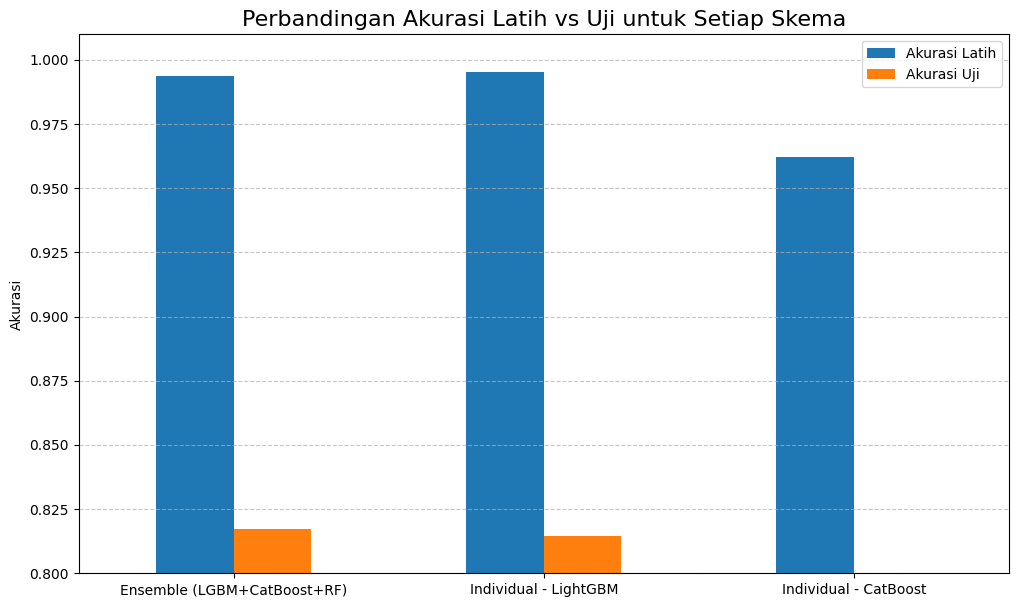


🏆 MODEL TERBAIK ADALAH: 'Ensemble (LGBM+CatBoost+RF)' 🏆
Dengan Akurasi pada Data Uji: 81.73%


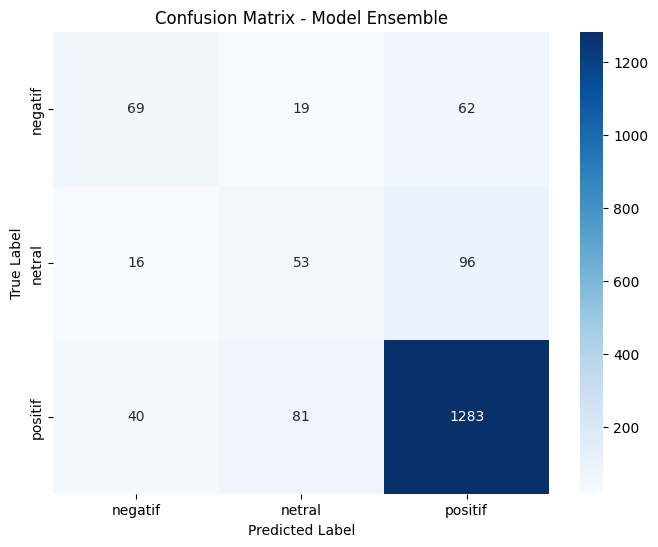

In [14]:
results_df = pd.DataFrame.from_dict(experiment_results, orient='index')
results_df.rename(columns={'train_acc': 'Akurasi Latih', 'test_acc': 'Akurasi Uji'}, inplace=True)
results_df.sort_values(by='Akurasi Uji', ascending=False, inplace=True)

print("\n\033[1mTabel Perbandingan Hasil Pelatihan Model\033[0m\n")
display(results_df.style.format("{:.2%}").background_gradient(cmap='viridis'))

results_df.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Perbandingan Akurasi Latih vs Uji untuk Setiap Skema', fontsize=16)
plt.ylabel('Akurasi')
plt.ylim(0.80, 1.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

if not results_df.empty:
    best_model_name = results_df.index[0]
    print(f"\n🏆 \033[1mMODEL TERBAIK ADALAH: '{best_model_name}'\033[0m 🏆")
    print(f"Dengan Akurasi pada Data Uji: \033[1m{results_df.loc[best_model_name, 'Akurasi Uji']:.2%}\033[0m")

# --- Confusion Matrix untuk Model Terbaik ---
best_model_predictions = ensemble_classifier.predict(X_test_features)
cm = confusion_matrix(y_test, best_model_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sentiment_mapping.keys(),
            yticklabels=sentiment_mapping.keys())
plt.title(f'Confusion Matrix - Model Ensemble')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## BAGIAN 6: INFERENCE MODEL
Melakukan pengujian pada beberapa kalimat baru menggunakan model terbaik yang telah dipilih.

In [15]:
# Fungsi bantuan untuk mengubah skor mentah (decision function) menjadi probabilitas
def softmax(scores):
    e_scores = np.exp(scores - np.max(scores))
    return e_scores / e_scores.sum()

# Contoh ulasan baru untuk diuji
new_reviews = [
    "Aplikasi ini sangat aman dan mudah digunakan, saya suka sekali!",
    "Setelah update terakhir sering error dan tidak bisa kirim gambar.",
    "Tidak ada yang spesial dari aplikasi ini.",
    "Terbaik untuk privasi, tidak ada tandingannya.",
    "biasa saja.",
    "kenapa sekarang jadi jelek banget ya"
]

sentiment_labels_map = {v: k for k, v in sentiment_mapping.items()}

# Pastikan best_model_for_inference sudah ada
if 'best_model_for_inference' in locals():
    print(f"\n--- HASIL PREDIKSI PADA KALIMAT BARU DENGAN MODEL TERBAIK: '{best_model_name}' ---")

    for review in new_reviews:
        # 1. Pra-pemrosesan teks baru
        stemmed_review = preprocess_text_only(review)
        
        # Buat fitur gabungan untuk satu review
        # NOTE: Kita harus menggunakan vectorizer yang sudah di-fit pada data training
        w2v_vector = vectorize(stemmed_review, w2v_model).reshape(1, -1)
        tfidf_vector = tfidf_vectorizer.transform([stemmed_review])
        combined_vector = hstack([tfidf_vector, w2v_vector]).tocsr()

        prediction_proba = None

        # 2. Logika prediksi yang robust untuk semua tipe model
        if isinstance(best_model_for_inference, tf.keras.Model):
            # Logika untuk model Keras/TensorFlow
            # NOTE: Model ini dilatih pada data vektor, bukan sekuens
            prediction_proba = best_model_for_inference.predict(combined_vector.toarray(), verbose=0)[0]

        elif isinstance(best_model_for_inference, ImbPipeline):
            # Logika untuk pipeline dari imblearn
            # REVISI FINAL: Menggunakan nama langkah 'classification'
            final_classifier = best_model_for_inference.named_steps['classification']
            if hasattr(final_classifier, 'predict_proba'):
                prediction_proba = best_model_for_inference.predict_proba(combined_vector)[0]
            else:
                scores = best_model_for_inference.decision_function(combined_vector)[0]
                prediction_proba = softmax(scores)

        elif CatBoostClassifier and isinstance(best_model_for_inference, CatBoostClassifier):
             # Logika spesifik untuk model CatBoost
             prediction_proba = best_model_for_inference.predict_proba(combined_vector)[0]

        elif hasattr(best_model_for_inference, 'predict_proba'):
             # Fallback untuk model sklearn lain seperti RandomForest
             prediction_proba = best_model_for_inference.predict_proba(combined_vector)[0]
        
        else:
            print(f"Tipe model '{type(best_model_for_inference).__name__}' tidak memiliki metode prediksi probabilitas yang dikenali.")
            continue

        # 3. Menampilkan Hasil dengan Probabilitas
        if prediction_proba is not None:
            prediction = np.argmax(prediction_proba)
            predicted_label = sentiment_labels_map.get(prediction, "Tidak Diketahui")

            print(f"\nUlasan: '{review}'")
            print(f"Prediksi Sentimen: {predicted_label.upper()}")
            
            print(f"  ├─ Prob. Negatif: {prediction_proba[sentiment_mapping['negatif']]:.2%}")
            print(f"  ├─ Prob. Netral:  {prediction_proba[sentiment_mapping['netral']]:.2%}")
            print(f"  └─ Prob. Positif: {prediction_proba[sentiment_mapping['positif']]:.2%}")
else:
    print("Model terbaik (best_model_for_inference) tidak ditemukan. Jalankan Bagian 5 terlebih dahulu.")

Model terbaik (best_model_for_inference) tidak ditemukan. Jalankan Bagian 5 terlebih dahulu.
